In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import os
import re
import csv
api_key = os.environ['GMAP_API']
%matplotlib inline

In [4]:
df = pd.read_csv('all_startups.csv')
del df['Unnamed: 0']
df.head()

,company_size,joined,location,market,name,pitch,raised,stage,website
0,1-10,Dec ’13,Singapore,Big Data,enMarkit,Social Engagement and Business Intelligence Pl...,"$11,700",-,enmarkit.com
1,1-10,Feb ’14,Silicon Valley,Productivity Software,Limitless,Intelligent cross device continuity,"$12,000",NaN,angel.co
2,1-10,Jul ’12,Detroit,Video Streaming,Reel Deal,Building College Community Through Entertainme...,"$12,000",Seed,ReelDeal.tv
3,1-10,Jul ’13,Raleigh,Lifestyle,Walk [Your City],Online tools to drive offline mobility and hel...,"$11,364",Seed,walkyourcity.org
4,1-10,Mar ’14,Ann Arbor,Business Services,Savvy Languages,"Free, easy way to learn languages online","$12,000",Seed,savvylanguages.com


In [ ]:
def get_location(loc):
    this_company = {}
    component = loc['location']
    url = 'https://maps.googleapis.com/maps/api/geocode/json'
    keys = {'address' : component, 'key': api_key}
    geo = requests.get(url,params=keys)
    geodata = geo.json()
    try:
        return geodata['results'][0]['formatted_address']
    except:
        print(loc['name'], component)

In [ ]:
df['location_long'] = df.apply(get_location, axis = 1)

In [ ]:
df = df.drop_duplicates()
df.to_csv('all_startups_geocoded.csv', index = False)

In [5]:
df = pd.read_csv('all_startups_geocoded.csv')

In [3]:
def get_usd(amnt, curr):
    url = 'https://www.google.com/search?q=1+'+str(curr)+'+in+usd'
    raw_html = requests.get(url)
    soup_doc = BeautifulSoup(raw_html.content, "html5lib")
    rate = float(soup_doc.find(class_ = 'J7UKTe').text.split(' = ')[1].replace(' United States Dollar', ''))
    return round(float(int(amnt)*rate), 2)

In [4]:
def get_currency(row):
    funding = row['raised']
    this_company={}
    this_company['raised_curr'] = re.findall(r'(^.*?)\d', funding)[0]
    this_company['raised_amnt'] = ''.join(re.findall(r'([\d]+)', funding))
    if this_company['raised_curr'] != '$':
        this_company['raised_amnt_orignal'] = this_company['raised_amnt']
        try:
            this_company['raised_amnt'] = get_usd(this_company['raised_amnt'], this_company['raised_curr'])
        except: 
            this_company['raised_amnt'] = 'ERROR'
            print(row['name'], funding)
    return pd.Series(this_company)

In [5]:
df = df.apply(get_currency, axis = 1).join(df)

HireMe €117,000
nyris €1,570,000
Triptease £11,040,000


In [7]:
df['joined'] = pd.to_datetime(df['joined'], format='%b ’%y')

,raised_amnt,raised_amnt_orignal,raised_curr,Unnamed: 0,company_size,joined,location,market,name,pitch,raised,stage,website,location_long
0,11700,NaN,$,0,1-10,2013-12-01,Singapore,Big Data,enMarkit,Social Engagement and Business Intelligence Pl...,"$11,700",-,enmarkit.com,Singapore
1,12000,NaN,$,1,1-10,2014-02-01,Silicon Valley,Productivity Software,Limitless,Intelligent cross device continuity,"$12,000",NaN,angel.co,"Silicon Valley, CA, USA"
2,12000,NaN,$,2,1-10,2012-07-01,Detroit,Video Streaming,Reel Deal,Building College Community Through Entertainme...,"$12,000",Seed,ReelDeal.tv,"Detroit, MI, USA"
3,11364,NaN,$,3,1-10,2013-07-01,Raleigh,Lifestyle,Walk [Your City],Online tools to drive offline mobility and hel...,"$11,364",Seed,walkyourcity.org,"Raleigh, NC, USA"
4,12000,NaN,$,4,1-10,2014-03-01,Ann Arbor,Business Services,Savvy Languages,"Free, easy way to learn languages online","$12,000",Seed,savvylanguages.com,"Ann Arbor, MI, USA"


In [8]:
df = pd.read_csv('all_startups_geocoded_currency.csv')
df.head()

,continent,country,state,raised_amnt,raised_amnt_orignal,raised_curr,Unnamed: 0,company_size,joined,location,market,name,pitch,raised,stage,website,location_long
0,Asia,Singapore,NaN,11700.0,NaN,$,0,1-10,2013-12-01,Singapore,Big Data,enMarkit,Social Engagement and Business Intelligence Pl...,"$11,700",-,enmarkit.com,Singapore
1,North America,USA,CA,12000.0,NaN,$,1,1-10,2014-02-01,Silicon Valley,Productivity Software,Limitless,Intelligent cross device continuity,"$12,000",NaN,angel.co,"Silicon Valley, CA, USA"
2,North America,USA,MI,12000.0,NaN,$,2,1-10,2012-07-01,Detroit,Video Streaming,Reel Deal,Building College Community Through Entertainme...,"$12,000",Seed,ReelDeal.tv,"Detroit, MI, USA"
3,North America,USA,NC,11364.0,NaN,$,3,1-10,2013-07-01,Raleigh,Lifestyle,Walk [Your City],Online tools to drive offline mobility and hel...,"$11,364",Seed,walkyourcity.org,"Raleigh, NC, USA"
4,North America,USA,MI,12000.0,NaN,$,4,1-10,2014-03-01,Ann Arbor,Business Services,Savvy Languages,"Free, easy way to learn languages online","$12,000",Seed,savvylanguages.com,"Ann Arbor, MI, USA"


In [7]:
#too lazy to check what went wrong - it's only 3 entries anyways
df = df[df.raised_amnt != 'ERROR']

/home/jls/.local/lib/python3.6/site-packages/pandas/core/ops.py:1167: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


TypeError: invalid type comparison

In [42]:
def get_country_state(row):
    location = row['location_long']
    this_location = {}
    try:
        locations = location.split(',')
        this_location['country'] = locations[-1].strip()
        if this_location['country'] == 'USA':
            this_location['state'] = re.findall(r'([A-Z]{2})', locations[-2])[0]            
    except:
        pass
        #this_location['country'] = location
    return pd.Series(this_location)

In [43]:
df = df.apply(get_country_state, axis = 1).join(df)

In [9]:
df.dtypes

continent               object
country                 object
state                   object
raised_amnt            float64
raised_amnt_orignal    float64
raised_curr             object
Unnamed: 0               int64
company_size            object
joined                  object
location                object
market                  object
name                    object
pitch                   object
raised                  object
stage                   object
website                 object
location_long           object
dtype: object

In [11]:
del df['Unnamed: 0']
df['raised_amnt'] = df.raised_amnt.astype(float)
df.dtypes

continent               object
country                 object
state                   object
raised_amnt            float64
raised_amnt_orignal    float64
raised_curr             object
company_size            object
joined                  object
location                object
market                  object
name                    object
pitch                   object
raised                  object
stage                   object
website                 object
location_long           object
dtype: object

In [44]:
df.head()

,country,state,raised_amnt,raised_amnt_orignal,raised_curr,Unnamed: 0,company_size,joined,location,market,name,pitch,raised,stage,website,location_long
0,Singapore,NaN,11700,NaN,$,0,1-10,2013-12-01,Singapore,Big Data,enMarkit,Social Engagement and Business Intelligence Pl...,"$11,700",-,enmarkit.com,Singapore
1,USA,CA,12000,NaN,$,1,1-10,2014-02-01,Silicon Valley,Productivity Software,Limitless,Intelligent cross device continuity,"$12,000",NaN,angel.co,"Silicon Valley, CA, USA"
2,USA,MI,12000,NaN,$,2,1-10,2012-07-01,Detroit,Video Streaming,Reel Deal,Building College Community Through Entertainme...,"$12,000",Seed,ReelDeal.tv,"Detroit, MI, USA"
3,USA,NC,11364,NaN,$,3,1-10,2013-07-01,Raleigh,Lifestyle,Walk [Your City],Online tools to drive offline mobility and hel...,"$11,364",Seed,walkyourcity.org,"Raleigh, NC, USA"
4,USA,MI,12000,NaN,$,4,1-10,2014-03-01,Ann Arbor,Business Services,Savvy Languages,"Free, easy way to learn languages online","$12,000",Seed,savvylanguages.com,"Ann Arbor, MI, USA"


In [12]:
with open('/home/jls/Dokumente/Lede/maps_basics/countries_africa.csv', 'r') as f:
    reader = csv.reader(f)
    africa = list(reader)
    
with open('/home/jls/Dokumente/Lede/maps_basics/countries_asia.csv', 'r') as f:
    reader = csv.reader(f)
    asia = list(reader)
    
with open('/home/jls/Dokumente/Lede/maps_basics/countries_europe.csv', 'r') as f:
    reader = csv.reader(f)
    europe = list(reader)
    
with open('/home/jls/Dokumente/Lede/maps_basics/countries_northam.csv', 'r') as f:
    reader = csv.reader(f)
    namerica = list(reader)
    
with open('/home/jls/Dokumente/Lede/maps_basics/countries_oceania.csv', 'r') as f:
    reader = csv.reader(f)
    oceania = list(reader)
    
with open('/home/jls/Dokumente/Lede/maps_basics/countries_southam.csv', 'r') as f:
    reader = csv.reader(f)
    samerica = list(reader)
world = africa + asia + europe + namerica + oceania + samerica
cont_list = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']

In [13]:
def get_continent(row):
    country = str(row['country'])
    n = 0
    for continent in world:
        if any(country in c for c in continent):
            return pd.Series({'continent' : cont_list[n]})
        n += 1

In [14]:
df = df.apply(get_continent, axis = 1).join(df)
df.head()

ValueError: columns overlap but no suffix specified: Index(['continent'], dtype='object')

In [98]:
df.to_csv('all_startups_geocoded_currency.csv', index = False)

## Stuff that's interesting:
Top Ten funded countries

Closer look: How's funding in the US distributed (time/state)

Top Ten funded Industries over time

Rise and Fall of startup trends: wearables / fintech / blockchain / vr & augmented reality

In [15]:
df.continent.value_counts()

North America    8398
Europe           1450
Asia              988
South America     289
Oceania           227
Africa             65
Name: continent, dtype: int64

continent
North America    1.037423e+11
Asia             1.976780e+10
Europe           6.595698e+09
Oceania          7.917219e+08
South America    5.562895e+08
Africa           1.919334e+08
Name: raised_amnt, dtype: float64


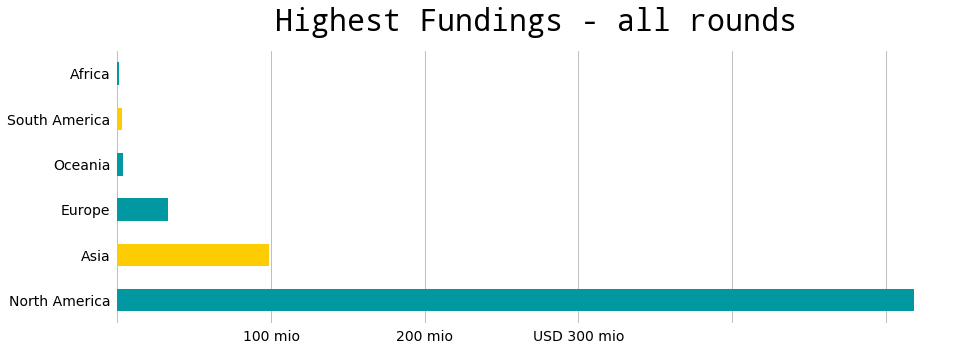

In [49]:
#df.groupby('country').sort_values(by = 'raised_amnt').raised_amnt.sum().plot(kind = 'bar')
bar_colors = ['#0198A1', '#FDCC03']
ax = df.groupby('continent').raised_amnt.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', fontsize = 14, figsize=(15,5), color=bar_colors, legend=False)
ax.set_title('Highest Fundings - all rounds', pad=20)
ax.title.set_fontsize(30)
ax.title.set_fontname("Noto Mono")
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(which='both', left=False, bottom=False)
ax.yaxis.label.set_visible(False)
#ax.set_xticks([0, 100000000, 200000000, 300000000])
ax.set_xticklabels(['', '100 mio', '200 mio', 'USD 300 mio'])
ax.grid(True, axis ='x')
ax.set_axisbelow(True)
#ax.set_xlim(0,300500000)
plt.savefig('bars-countries.pdf')
plt.savefig('bars-countries.png')

print(df.groupby('continent').raised_amnt.sum().sort_values(ascending = False).head(10))

name
Flipkart           1.482214e+10
Uber               1.225245e+10
StemCentRx         1.047350e+10
Snapchat           3.819085e+09
Lyft               2.612500e+09
Fast Track Asia    2.147484e+09
Sprinklr           2.028500e+09
SoFi               1.712200e+09
Ten-X              1.600000e+09
Spotify            1.421640e+09
Name: raised_amnt, dtype: float64


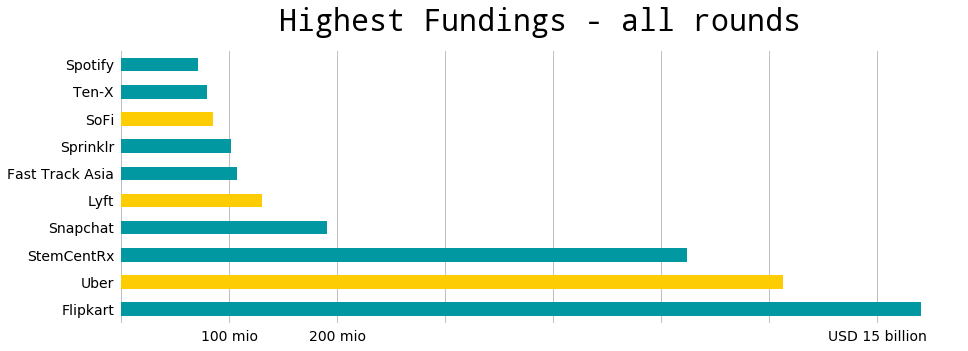

In [50]:
print(df.groupby('name').raised_amnt.sum().sort_values(ascending = False).head(10))
bar_colors = ['#0198A1', '#FDCC03']
ax = df.groupby('name').raised_amnt.sum().sort_values(ascending = False).head(10).plot(kind = 'barh', fontsize = 14, figsize=(15,5), color=bar_colors, legend=False)
ax.set_title('Highest Fundings - all rounds', pad=20)
ax.title.set_fontsize(30)
ax.title.set_fontname("Noto Mono")
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(which='both', left=False, bottom=False)
ax.yaxis.label.set_visible(False)
#ax.set_xticks([0, 10000000000, 20000000000, 30000000000])
ax.set_xticklabels(['', '100 mio', '200 mio','','','','', 'USD 15 billion'])
ax.grid(True, axis ='x')
ax.set_axisbelow(True)
ax.set_xlim(0,15500000000)
plt.savefig('bars-companies.pdf')
plt.savefig('bars-companies.png')

In [ ]:
label = []
for state in df.state:
    if df[df['state'] == state].raisedAmt.sum() > 266300000:
        label.append(state)
label = list(set(label))
single_states = label
label.append('other')

sum_ = []
for state in label:
    if state != 'other':
        sum_.append(df[df['state'] == state].raisedAmt.sum())
    else:
        sum_.append(df[~df.state.isin(single_states)].raisedAmt.sum())

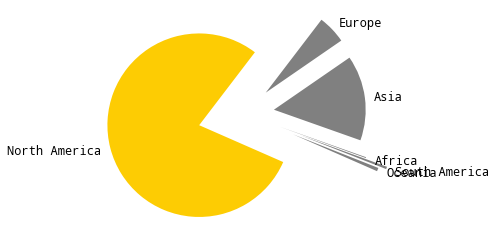

In [51]:
colors = ['grey', 'grey', 'grey', '#FDCC03', 'grey', 'grey']

# Create a pie chart
plt.pie(
    df.groupby('continent').raised_amnt.sum(),
    labels=cont_list,
    shadow=False,
    colors=colors,
    explode=(0.5, 0.4, 0.4, 0.6, 0.7, 0.8),
    startangle=-20,
    radius = 1.2,
    wedgeprops = {'linewidth': 0},
    textprops = {'fontsize':12, 'fontname':'Noto Mono'}
    )
#plt.pie?
plt.axis('equal')
#plt.tight_layout()
plt.savefig('pie.pdf')
plt.savefig('pie.png')
plt.show()

In [27]:
df_us = df[~df.state.isna()]
df_us.groupby('state').raised_amnt.sum().sort_values(ascending = False).head(10)

state
CA    6.913026e+10
NY    1.037254e+10
MA    7.214117e+09
TX    2.401327e+09
WA    1.325218e+09
IL    1.274537e+09
CO    1.037060e+09
KS    9.943758e+08
DC    8.319620e+08
AZ    7.985748e+08
Name: raised_amnt, dtype: float64

In [28]:
import squarify

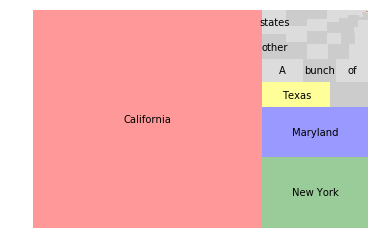

In [52]:
color=["red","green","blue", 'yellow', "grey", "darkgrey", "grey", "darkgrey", "grey", "darkgrey", "grey", "darkgrey", "grey", "darkgrey", "grey", "darkgrey", "grey", "darkgrey", "grey", "darkgrey", "grey", "darkgrey", "grey", "darkgrey", "grey", "darkgrey", "grey", "darkgrey", "grey", "darkgrey", "grey", "darkgrey", "grey", "darkgrey", "grey", "darkgrey", "grey", "darkgrey", "grey", "darkgrey"]
squarify.plot(df_us.groupby('state').raised_amnt.sum().sort_values(ascending = False), color = color, label = ['California', 'New York', 'Maryland', 'Texas', '', 'A', 'bunch', 'of', 'other', 'states'], alpha=.4 )
plt.axis('off')
plt.savefig('square.pdf')
plt.savefig('square.png')
plt.show()

In [30]:
df_us.groupby('market').raised_amnt.sum().sort_values(ascending = False).head(10)

market
Technology              1.508795e+10
Video Streaming         4.665709e+09
College Campuses        2.613861e+09
Blogging Platforms      2.236212e+09
Consumer Electronics    2.142036e+09
Web Development         2.060600e+09
Enterprise Security     2.037692e+09
Consumer Lending        1.996900e+09
-                       1.824485e+09
Developer Tools         1.670211e+09
Name: raised_amnt, dtype: float64

In [31]:
df_timeline = df.groupby('joined').raised_amnt.sum().reset_index()
df_timeline.head()

,joined,raised_amnt
0,2009-11-01,1.952500e+07
1,2010-04-01,2.797250e+08
2,2010-05-01,1.415000e+07
3,2010-06-01,1.225945e+10
4,2010-07-01,2.280120e+08


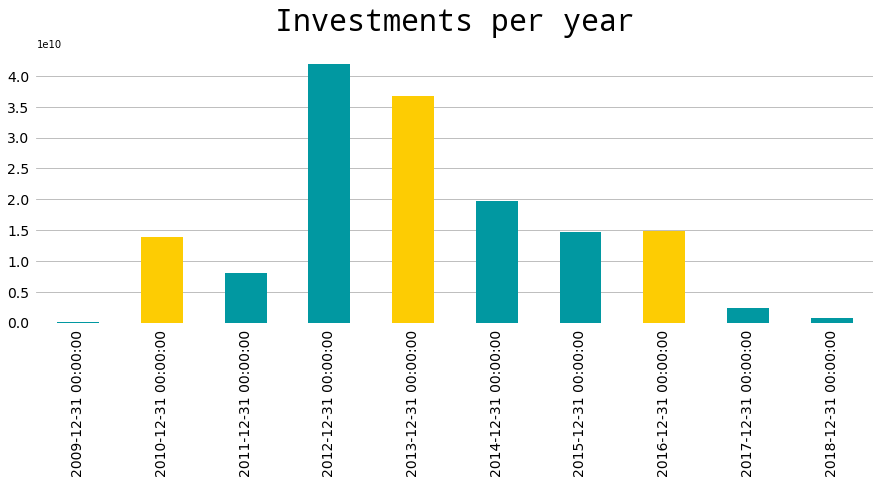

In [53]:
df_timeline['joined'] = pd.to_datetime(df_timeline['joined'])
bar_colors = ['#0198A1', '#FDCC03']
ax = df_timeline.resample('Y', on = 'joined').raised_amnt.sum().plot(kind = 'bar', fontsize = 14, figsize=(15,5), color=bar_colors, legend=False)
ax.set_title('Investments per year', pad=20)
ax.title.set_fontsize(30)
ax.title.set_fontname("Noto Mono")
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(which='both', left=False, bottom=False)
ax.yaxis.label.set_visible(False)
ax.xaxis.label.set_visible(False)
#ax.set_xticks([0, 10000000000, 20000000000, 30000000000])
#ax.set_xticklabels(['', '100 mio', '200 mio','','','','', 'USD 15 billion'])
ax.grid(True, axis ='y')
ax.set_axisbelow(True)
#ax.set_xlim(0,15500000000)
plt.savefig('sum-time.pdf')
plt.savefig('sum-time.png')

In [224]:
buzzword = 'Internet of Things'

df_temp = df[df['pitch'].str.contains(buzzword, na=False, regex=True) | df['market'].str.contains(buzzword, na=False, regex=True)]
df_temp.head()

,continent,country,state,raised_amnt,raised_amnt_orignal,raised_curr,Unnamed: 0,company_size,joined,location,market,name,pitch,raised,stage,website,location_long
73,North America,USA,PA,15000.0,NaN,$,73,1-10,2017-01-01,Philadelphia,Internet of Things,GuestOf,Access & Identity as a service - for the physi...,"$15,000",Closed,guestofapp.com,"Philadelphia, PA, USA"
93,North America,USA,PA,15000.0,NaN,$,93,1-10,2017-01-01,Philadelphia,Internet of Things,GuestOf,Access & Identity as a service - for the physi...,"$15,000",Closed,guestofapp.com,"Philadelphia, PA, USA"
481,None,UK,NaN,33000.0,NaN,$,481,1-10,2015-01-01,Newcastle upon Tyne,Internet of Things,RESTACK,The universal interface for connected devices.,"$33,000",Seed,restack.io,"Newcastle upon Tyne, UK"
753,North America,USA,CO,40000.0,NaN,$,753,1-10,2014-02-01,Denver,Internet of Things,Building Brains,Building Brains for your Buildings,"$40,000",Closed,BuildingBrains.co,"Denver, CO, USA"
931,North America,USA,CA,50000.0,NaN,$,931,1-10,2016-03-01,San Mateo,Internet of Things,ZoomThru,Connecting the parking industry through networ...,"$50,000",Seed,zoomthru.co,"San Mateo, CA, USA"


Text(0,0.5,'Life expectancy at birth')

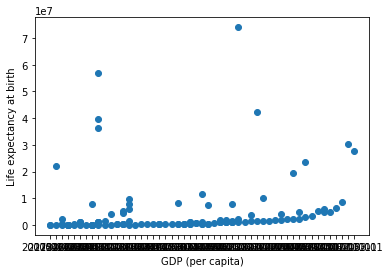

In [227]:
# Initialize a new figure
fig, ax = plt.subplots()

# Draw the graph
ax.plot(df_temp['joined'], df_temp['raised_amnt'], linestyle='', marker='o')

# Set the label for the x-axis
ax.set_xlabel("GDP (per capita)")

# Set the label for the y-axis
ax.set_ylabel("Life expectancy at birth")

In [ ]:
df.resample('A', on = 'created_at').count().created_at.plot()